<a href="https://colab.research.google.com/github/Jothish2283/MachineLearning/blob/main/Cats_Vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
main_file_path="/content/drive/MyDrive/ML/DL/CV/Binary/Cats_VS_Dogs/dogs_vs_cats.zip"

In [ ]:
import zipfile

def extract(file_path):
  zip_ref=zipfile.ZipFile(file_path)
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
extract(main_file_path)

In [ ]:
extract("train.zip")

#**Preprocessing data**

In [ ]:
import tensorflow as tf
import random

cat_path=tf.io.gfile.glob("train/cat.*.jpg")
dog_path=tf.io.gfile.glob("train/dog.*.jpg")
random.shuffle(cat_path)
random.shuffle(dog_path)

In [ ]:
from sklearn.model_selection import train_test_split

train_cat_path, test_cat_path=train_test_split(cat_path,
                                               test_size=0.2)
train_dog_path, test_dog_path=train_test_split(dog_path,
                                               test_size=0.2)

paths=[train_cat_path, train_dog_path, test_cat_path, test_dog_path]

In [ ]:
import os
os.mkdir("train_data")
os.mkdir("test_data")
dir_paths=["train_data/cat", "train_data/dog", "test_data/cat", "test_data/dog"]
for dir_path in dir_paths:
  os.mkdir(dir_path)

In [ ]:
import shutil

for i in range(4):
  for path in paths[i]:
    shutil.copy2(path,dir_paths[i])

In [ ]:
classes=["cat", "dog"]

In [ ]:
train_data=tf.keras.utils.image_dataset_from_directory(directory="train_data")
test_data=tf.keras.utils.image_dataset_from_directory(directory="test_data")

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


#**Viewing random samples**

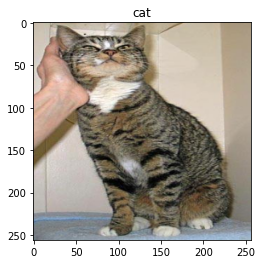

In [ ]:
import matplotlib.pyplot as plt
random_index=random.randint(0,32)
for image, label in train_data.take(1):
  plt.title(classes[label[random_index]])
  plt.imshow(image[random_index]/255)


#**Callbacks**

In [ ]:
def tensorboard_callback(dir_path):
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=dir_path)
  print("saving tensorboard files to:",dir_path)
  return tensorboard_callback

def early_stopping():
  early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)
  return early_stopping

def reduce_lr():
  reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                 factor=0.1,
                                                 patience=2,
                                                 min_lr=1e-7)
  return reduce_lr
  

#**Model_0**: Tiny VGG 

In [ ]:
inputs= tf.keras.layers.Input((256,256,3))
x=tf.keras.layers.Conv2D(64, 3, activation="relu")(inputs)
x=tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
x=tf.keras.layers.MaxPool2D()(x)
x=tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
x=tf.keras.layers.Conv2D(16, 3, activation="relu")(x)
x=tf.keras.layers.MaxPool2D()(x)
x=tf.keras.layers.Conv2D(64, 2, activation="relu")(x)
x=tf.keras.layers.Conv2D(16, 2, activation="relu")(x)
x=tf.keras.layers.MaxPool2D()(x)
x=tf.keras.layers.GlobalMaxPool2D()(x)
outputs=tf.keras.layers.Dense(2, activation="softmax")(x)

model_0=tf.keras.Model(inputs, outputs)

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 16)      9232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      9280      
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 16)      9232      
                                                             

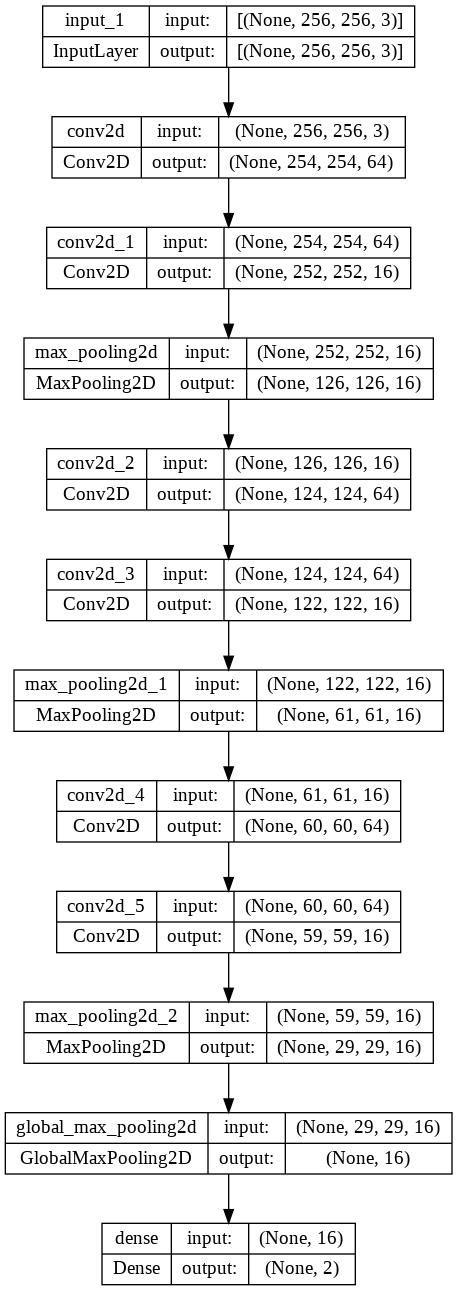

In [ ]:
tf.keras.utils.plot_model(model_0, show_shapes=True)

In [ ]:
model_0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_0=model_0.fit(train_data,
                      epochs=3,
                      #callbacks=[reduce_lr(), tensorboard_callback("tensorboard/model_0"), early_stopping()],
                      validation_data=(test_data))

Epoch 1/3
625/625 [==============================] - 109s 157ms/step - loss: 0.6929 - accuracy: 0.5707 - val_loss: 0.6517 - val_accuracy: 0.6242
Epoch 2/3
625/625 [==============================] - 98s 157ms/step - loss: 0.6449 - accuracy: 0.6363 - val_loss: 0.6162 - val_accuracy: 0.6640
Epoch 3/3
625/625 [==============================] - 99s 157ms/step - loss: 0.6179 - accuracy: 0.6618 - val_loss: 0.5974 - val_accuracy: 0.6904


#**Visualising the learnt patterns**

In [ ]:
#input and output shapes of layers
for layer_no,layer in enumerate(model_0.layers):
  if "conv2d" in layer.name:
    print(layer_no, layer.name, layer.output.shape)

1 conv2d (None, 254, 254, 64)
2 conv2d_1 (None, 252, 252, 16)
4 conv2d_2 (None, 124, 124, 64)
5 conv2d_3 (None, 122, 122, 16)
7 conv2d_4 (None, 60, 60, 64)
8 conv2d_5 (None, 59, 59, 16)


In [ ]:
#shapes of filters used in the layers
for layer_no,layer in enumerate(model_0.layers):
  if "conv2d" in layer.name:
    filters, bias= layer.get_weights()
    print(layer_no, layer.name, filters.shape)

1 conv2d (3, 3, 3, 64)
2 conv2d_1 (3, 3, 64, 16)
4 conv2d_2 (3, 3, 16, 64)
5 conv2d_3 (3, 3, 64, 16)
7 conv2d_4 (2, 2, 16, 64)
8 conv2d_5 (2, 2, 64, 16)


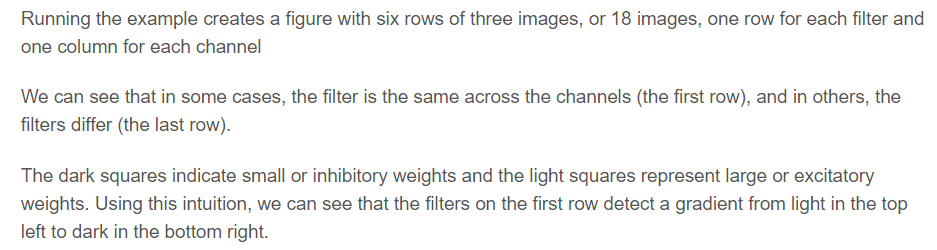

**Feature maps of first conv layer**

In [ ]:
filters, baises= model_0.layers[1].get_weights()

In [ ]:
f_min, f_max= filters.min(), filters.max()
filters=(filters-f_min)/(f_max-f_min)

In [ ]:
filters.shape

(3, 3, 3, 64)

In [ ]:
filters[:,:,:,0].shape

(3, 3, 3)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
filters[:,:,:,2], filters[:,:,:,2].shape

(array([[[0.50268185, 0.5816786 , 0.21985227],
         [0.54695386, 0.31290597, 0.9283585 ],
         [0.34472364, 0.7759687 , 0.39693227]],
 
        [[0.71676624, 0.5619153 , 0.60898244],
         [0.82759565, 0.2759137 , 0.65778947],
         [0.64278996, 0.5973543 , 0.689872  ]],
 
        [[0.26466933, 0.75263256, 0.22067782],
         [0.83537436, 0.78593135, 0.23253053],
         [0.8554715 , 0.61170584, 0.68850225]]], dtype=float32), (3, 3, 3))

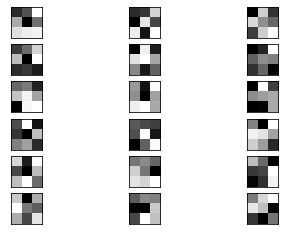

In [ ]:
#viewing first 5 filters
n_filter, ix=6, 1
for i in range(n_filter):
  filter_weights=filters[:,:,:,i]
  for j in range(3):
    ax=plt.subplot(n_filter,3,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(filter_weights[:,:,j], cmap="gray")
    ix+=1
plt.show()

In [ ]:
model_conv_layer_1=tf.keras.Model(model_0.inputs, model_0.layers[1].output)

In [ ]:
img_path="/content/drive/MyDrive/ML/DL/CV/Binary/Cats_VS_Dogs/custom_images/cat_1.jpg"
img=tf.io.read_file(img_path)
img=tf.io.decode_image(img)
img=tf.image.resize(img,[256,256])
img=tf.expand_dims(img, axis=0)
img=(img/255)
img.shape

TensorShape([1, 256, 256, 3])

In [ ]:
feature_map=model_conv_layer_1.predict(img)
feature_map.shape

1/1 [==============================] - 0s 96ms/step


(1, 254, 254, 64)

<ipython-input-32-4e0a25708fa6>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax=plt.subplots(figsize=(2,2));


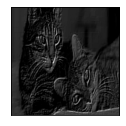

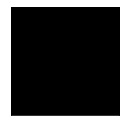

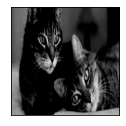

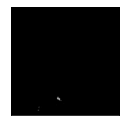

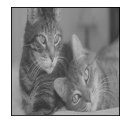

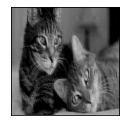

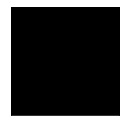

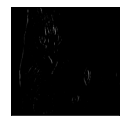

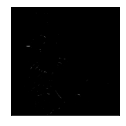

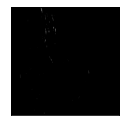

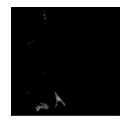

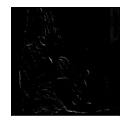

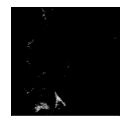

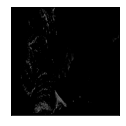

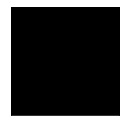

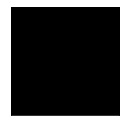

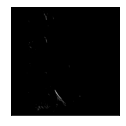

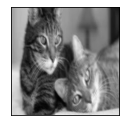

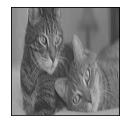

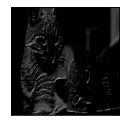

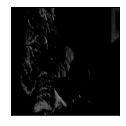

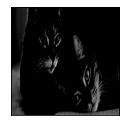

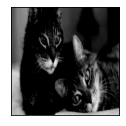

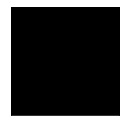

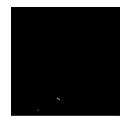

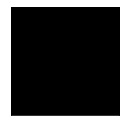

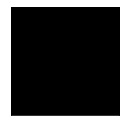

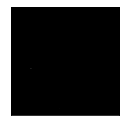

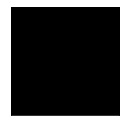

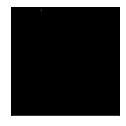

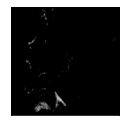

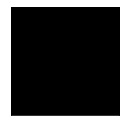

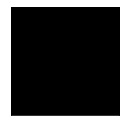

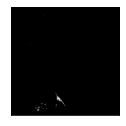

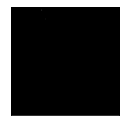

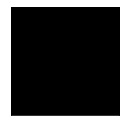

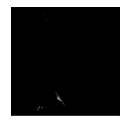

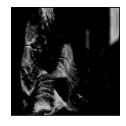

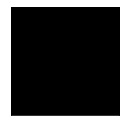

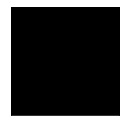

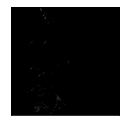

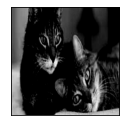

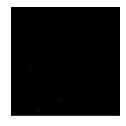

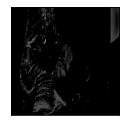

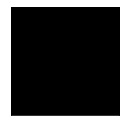

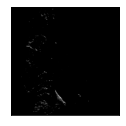

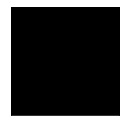

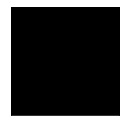

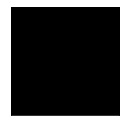

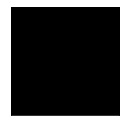

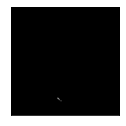

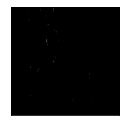

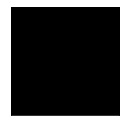

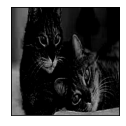

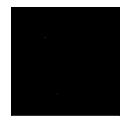

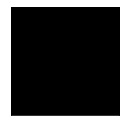

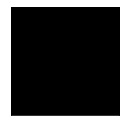

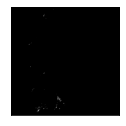

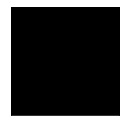

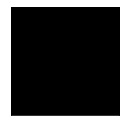

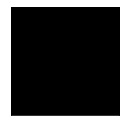

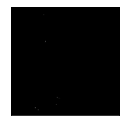

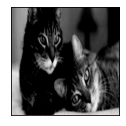

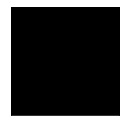

In [ ]:
square, ix=8, 1
for _ in range(square):
  for _ in range(square):
    fig, ax=plt.subplots(figsize=(2,2));
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_map[0,:,:,ix-1],cmap="gray")
    ix+=1
plt.show()

**Feature maps of last convolution layer**

In [ ]:
filters, bias =model_0.layers[8].get_weights()

In [ ]:
f_max, f_min= filters.max(), filters.min()
filters=(filters-f_min)/(f_max-f_min)
filters.shape

(2, 2, 64, 16)

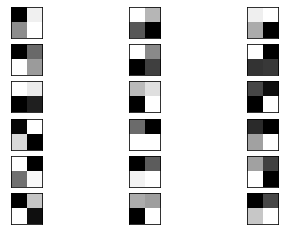

In [ ]:
ix=1
for i in range(n_filter):
  filter_weights=filters[:,:,:,i]
  for j in range(3):
    ax=plt.subplot(n_filter, 3, ix)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.imshow(filter_weights[:,:,j],cmap="gray")
    ix+=1

In [ ]:
model_conv_layer_6=tf.keras.Model(model_0.input, model_0.layers[8].output)
model_conv_layer_6.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 16)      9232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      9280      
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 16)      9232      
                                                           

In [ ]:
img_path="/content/drive/MyDrive/ML/DL/CV/Binary/Cats_VS_Dogs/custom_images/cat_1.jpg"
img=tf.io.read_file(img_path)
img=tf.io.decode_image(img)
img=tf.image.resize(img,[256,256])
img=tf.expand_dims(img, axis=0)
img=(img/255)
img.shape

TensorShape([1, 256, 256, 3])

In [ ]:
feature_map=model_conv_layer_6.predict(img)
feature_map.shape

1/1 [==============================] - 0s 15ms/step


(1, 59, 59, 16)

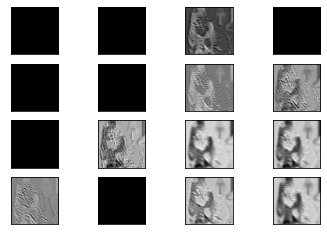

In [ ]:
square, ix=4, 1
for _ in range(square):
  for _ in range(square):
    ax=plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_map[0,:,:,ix-1],cmap="gray")
    ix+=1
plt.show()

#**Model_1**:Transfer Learning

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="float32")

In [ ]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

mixed_precision.set_global_policy(policy="mixed_float16")
inputs=tf.keras.layers.Input((256,256,3))
x=base_model(inputs)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(2, activation="softmax", dtype=tf.float32)(x)

model_1=tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1=model_1.fit(train_data,
                      epochs=100,
                      callbacks=[reduce_lr(), tensorboard_callback("tensorboard/model_1_b4_finetuning"), early_stopping()],
                      validation_data=(test_data))

saving tensorboard files to: tensorboard/model_1_b4_finetuning
Epoch 1/100
625/625 [==============================] - 82s 115ms/step - loss: 0.0400 - accuracy: 0.9890 - val_loss: 0.0244 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 2/100
625/625 [==============================] - 70s 112ms/step - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0230 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 3/100
625/625 [==============================] - 69s 110ms/step - loss: 0.0175 - accuracy: 0.9941 - val_loss: 0.0225 - val_accuracy: 0.9914 - lr: 0.0010
Epoch 4/100
625/625 [==============================] - 71s 112ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0221 - val_accuracy: 0.9918 - lr: 0.0010
Epoch 5/100
625/625 [==============================] - 69s 111ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.0220 - val_accuracy: 0.9918 - lr: 1.0000e-04


**Fine tuning**

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-5]:
  layer.trainable=False
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

hitory_2=model_1.fit(train_data,
                     epochs=1000,
                     initial_epoch=history_1.epoch[-1],
                     callbacks=[reduce_lr(), tensorboard_callback("tensorboard/model_1_after_finetuning"), early_stopping()],
                     validation_data=(test_data))

saving tensorboard files to: tensorboard/model_1_after_finetuning
Epoch 5/1000
625/625 [==============================] - 79s 116ms/step - loss: 0.0355 - accuracy: 0.9894 - val_loss: 0.0364 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 6/1000
625/625 [==============================] - 72s 115ms/step - loss: 0.0159 - accuracy: 0.9951 - val_loss: 0.0340 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 7/1000
625/625 [==============================] - 72s 114ms/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 0.0318 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 8/1000
625/625 [==============================] - 72s 115ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.0314 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 9/1000
625/625 [==============================] - 71s 114ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0266 - val_accuracy: 0.9926 - lr: 1.0000e-04
Epoch 10/1000
625/625 [==============================] - 71s 114ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0267 - val

In [ ]:
y_preds=model_1.predict(test_data)

157/157 [==============================] - 14s 82ms/step


In [ ]:
y_preds=tf.argmax(y_preds, axis=1)

#**Custom images**

In [ ]:
custom_img_dir="/content/drive/MyDrive/ML/DL/CV/Binary/Cats_VS_Dogs/custom_images"

1/1 [==============================] - 1s 1s/step


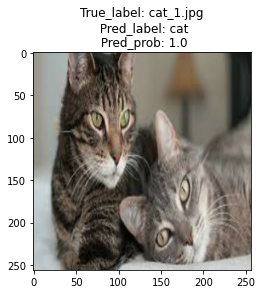

1/1 [==============================] - 0s 24ms/step


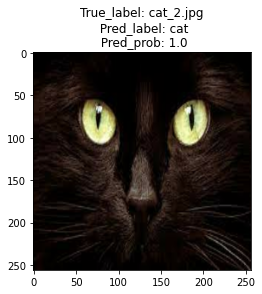

1/1 [==============================] - 0s 105ms/step


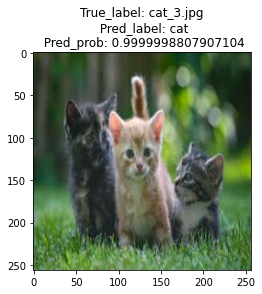

1/1 [==============================] - 0s 23ms/step


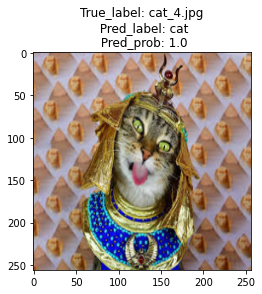

1/1 [==============================] - 0s 23ms/step


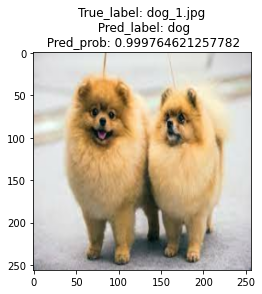

1/1 [==============================] - 0s 25ms/step


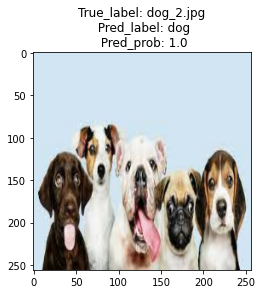

1/1 [==============================] - 0s 23ms/step


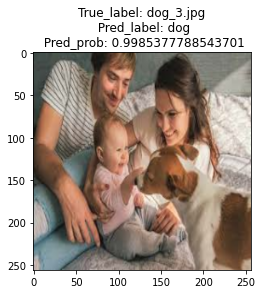

1/1 [==============================] - 0s 30ms/step


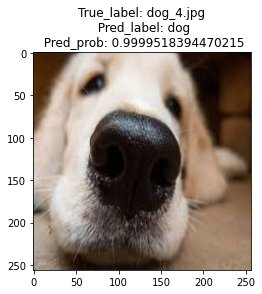

1/1 [==============================] - 0s 45ms/step


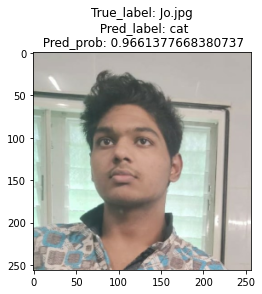

1/1 [==============================] - 0s 23ms/step


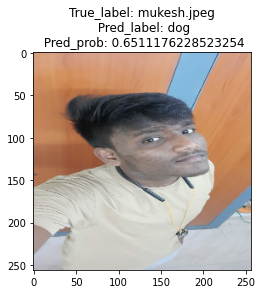

In [ ]:
for image in os.listdir(custom_img_dir):
  img_path=custom_img_dir+"/"+image
  img=tf.io.read_file(img_path)
  img=tf.io.decode_image(img)
  img=tf.image.resize(img,[256,256])
  y_pred=model_1.predict(tf.expand_dims(img, axis=0))
  plt.imshow(img/255)
  plt.title(f"True_label: {image}\n Pred_label: {classes[y_pred.argmax()]}\n Pred_prob: {y_pred.max()}")
  plt.show()

#**Tensorboard results**:https://tensorboard.dev/experiment/Ajk4jFE4TXSpA7D36oQETA/

In [ ]:
# !tensorboard dev upload --logdir ./tensorboard/\
# --name "Cats VS Dogs"\
# --one_shot